In [ ]:
# source .venv/bin/activate


In [7]:
import os
import wave
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm  
from skimage.transform import resize
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import train_test_split

In [2]:

# Walk through all subfolders in 'insular' and 'pelagic' looking for .wav files, append to 'data' 
# if over 1 second
def get_wav_files_and_labels(base_dir, min_duration=1.0):
    data = []
    for label in ['Insular', 'Pelagic']:
        label_path = os.path.join(base_dir, label)
        for root, dirs, files in os.walk(label_path):
            if os.path.basename(root) == "Raven wave file clips":
                for f in files:
                    if f.lower().endswith('.wav'):
                        full_path = os.path.join(root, f)
                        try:
                            with wave.open(full_path, 'rb') as wf:
                                frames = wf.getnframes()
                                rate = wf.getframerate()
                                duration = frames / float(rate)
                                if duration >= min_duration:
                                    data.append((full_path, label))
                        except wave.Error as e:
                            print(f"Could not process {full_path}: {e}")
    return data

# Return no. of spectrograms >1 second
base_dir = '../data'
wav_label_pairs = get_wav_files_and_labels(base_dir)
print(f"Found {len(wav_label_pairs)} wav files at least 1 second long.")


Found 2073 wav files at least 1 second long.


In [3]:
wav_label_pairs

[('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_205743_sel_29.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_205743_sel_15.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_205743_sel_01.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_205443_sel_09.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_210443_sel_02.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204443_sel_13.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204443_sel_07.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204643_sel_20.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204643_sel_08.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204643_sel_09.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_33

In [ ]:
# Function for creating a subset of wav_label_pairs

def create_balanced_subset(wav_label_pairs, n=20):
    # Separate by label
    insular = [pair for pair in wav_label_pairs if pair[1] == 'Insular']
    pelagic = [pair for pair in wav_label_pairs if pair[1] == 'Pelagic']

    # Make sure there are enough samples
    if len(insular) < n or len(pelagic) < n:
        raise ValueError(f"Not enough samples: Found {len(insular)} Insular and {len(pelagic)} Pelagic.")

    # Randomly sample n from each
    subset = random.sample(insular, n) + random.sample(pelagic, n)

    # Shuffle the combined subset - good for ML
    random.shuffle(subset)

    return subset

# Create the dataset subset
wav_label_sub = create_balanced_subset(wav_label_pairs, n=20)
print(f"Subset contains {len(wav_label_sub)} samples.")


Subset contains 40 samples.


In [5]:
wav_label_sub

[('../data/Insular/Sette_AC_340/Raven wave file clips/20171008_233843_sel_02.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_340/Raven wave file clips/20171008_234543_sel_03.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_205743_sel_23.wav',
  'Insular'),
 ('../data/Pelagic/Pelagic/Sette_AC_258/Raven wave file clips/20170913_180235_sel_15.wav',
  'Pelagic'),
 ('../data/Pelagic/Pelagic/Sette_Ac_101/Raven wave file clips/20170728_032159_ch06_sel40.wav',
  'Pelagic'),
 ('../data/Pelagic/Pelagic/Sette_AC_258/Raven wave file clips/20170913_183435_sel_02.wav',
  'Pelagic'),
 ('../data/Pelagic/Pelagic/Sette_Ac_101/Raven wave file clips/20170728_032159_ch06_sel50.wav',
  'Pelagic'),
 ('../data/Pelagic/Pelagic/Sette_AC_258/Raven wave file clips/20170913_183435_sel_07.wav',
  'Pelagic'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204643_sel_09.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204443_sel_10.wa

In [6]:
# Create spectrograms and resize
def wav_to_spectrogram_scipy(wav_path, n_fft=8192):
    sample_rate, samples = wavfile.read(wav_path)
    frequencies, times, Sxx = signal.spectrogram(samples, sample_rate, nperseg=n_fft)
    # Sxx is power spectral density, take log to get dB scale
    Sxx_log = np.log(Sxx + 1e-10)  # add small number to avoid log(0)
    # Normalize to 0-1 range
    Sxx_norm = (Sxx_log - Sxx_log.min()) / (Sxx_log.max() - Sxx_log.min())
    return Sxx_norm


spectrograms = []
labels = []

for wav_path, label in tqdm(wav_label_sub):
    spect = wav_to_spectrogram_scipy(wav_path, n_fft=8192)
    spectrograms.append(spect)
    labels.append(label)



target_shape = (128, 128)
spectrograms_resized = []
valid_labels = []

for i, (s, label) in enumerate(zip(spectrograms, labels)):
    try:
        resized = resize(s, target_shape, mode='constant', anti_aliasing=True)

        # Fix extra singleton dimension if it appears
        if resized.ndim == 3 and resized.shape[-1] == 1:
            resized = np.squeeze(resized, axis=-1)

        # Final shape check
        if resized.shape != target_shape:
            print(f"Warning: Resized shape mismatch at index {i}, got {resized.shape}")
            continue

        spectrograms_resized.append(resized)
        valid_labels.append(label)  # keep label only if resize succeeded

    except Exception as e:
        print(f"Error resizing spectrogram at index {i}: {e}")


        
# Encode labels to integers
label_to_idx = {'Insular': 0, 'Pelagic': 1}
y = np.array([label_to_idx[l] for l in valid_labels])



 68%|██████▊   | 27/40 [00:02<00:01, 12.55it/s]/var/folders/bt/njml01qd5wzbf3cq1pr211xw0000gp/T/ipykernel_2864/3021039634.py:4: UserWarning: nperseg = 8192 is greater than input length  = 5, using nperseg = 5
  frequencies, times, Sxx = signal.spectrogram(samples, sample_rate, nperseg=n_fft)
 78%|███████▊  | 31/40 [00:03<00:01,  6.40it/s]/var/folders/bt/njml01qd5wzbf3cq1pr211xw0000gp/T/ipykernel_2864/3021039634.py:4: UserWarning: nperseg = 8192 is greater than input length  = 6, using nperseg = 6
  frequencies, times, Sxx = signal.spectrogram(samples, sample_rate, nperseg=n_fft)
100%|██████████| 40/40 [00:05<00:00,  6.83it/s]


Spectrogram dataset shape: (40, 128, 128)
Labels shape: (40,)


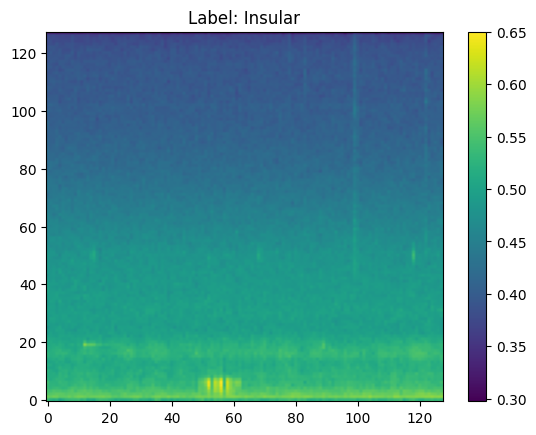

In [8]:
# turn into numpy array and check shape
spectrograms_resized = np.array(spectrograms_resized)
print(f"Spectrogram dataset shape: {spectrograms_resized.shape}")
print(f"Labels shape: {y.shape}")

# To visualize one spectrogram
plt.imshow(spectrograms_resized[0], aspect='auto', origin='lower')
plt.title(f"Label: {valid_labels[0]}")
plt.colorbar()
plt.show()